In [1]:
import os
import sys
from dotenv import load_dotenv
import yaml

load_dotenv()
DVUTILS_LOCAL_CLONE_PATH = os.environ.get("DVUTILS_LOCAL_CLONE_PATH")
sys.path.insert(0, DVUTILS_LOCAL_CLONE_PATH)

from utils_io import *

Info: Found credentials at: /Users/lelias/Library/CloudStorage/Box-Box/dvutils-creds-lelias.json


## Define Parameters

In [2]:
## Set the PCA Layers configuration file: PCA Geographies and PCA Types
yaml_file = 'pca-layers.yml'

## Create ArcGIS Client
client = create_arcgis_client()

Admin ArcGIS client created


## Create Functions

In [3]:
def simplify_geoms(gdf):
    """Simplify and clean Geometries by applying dissolve, explode,
    simplify and repair_geometry functions
    """
    print(f"GDF Geometry Types: {gdf.geom_type.unique()}")
    ## Convert Multipart features to Single part
    gdf = gdf.dissolve(by=None).reset_index(drop=True)
    gdf = gdf.explode(index_parts=False).reset_index(drop=True)
    ## Repair Geometries
    gdf = repair_geometry(gdf.query("geometry.notnull()"))
    print(f"GDF Geometry Types: {gdf.geom_type.unique()}")

    return gdf


def create_footprint(gdf, flag_name, dist=False):
    """Create Area Footprint from GeoDataframe and assign Flag Name
    to Column
    """
    ## Simplify Dataset
    gdf = gdf[["geometry"]].copy()
    gdf = simplify_geoms(gdf)
    ## Set Area Name
    gdf[flag_name] = 1

    return gdf


def create_footprints_for_dict(input_dict, flag_name):
    """Iterate through Dictionary object and create area footprints
    by applying the create_footprint function
    """
    for k, v in input_dict.items():
        print(f"Creating Footprint for dataset: {k}")
        try:
            data_key = "data" if "data" in v else "data_load"
            print(f"Using: {data_key}")
            v["footprint"] = create_footprint(v[data_key], v[flag_name])
            v["footprint"].plot()
            print("Creation of Footprint completed\n")
        except:
            print("Creation of Footprint failed!\n")

## Load PCA Layers definitions from YAML

In [4]:
## Load PCA Geographies from YAML
with open(yaml_file, 'r') as file:
    pca_geo = yaml.safe_load(file)['pca_geo']
print(pca_geo)

## Load PCA Types from YAML
with open(yaml_file, 'r') as file:
    pca_types = yaml.safe_load(file)['pca_types']
print([i for i in pca_types.keys()])

{'name': 'PCA Geographies', 'agol': 'https://www.arcgis.com/home/item.html?id=8f4a98b1bb32402db22ba7379ea062a9', 'url': 'https://services3.arcgis.com/i2dkYWmb4wHvYPda/arcgis/rest/services/PBA50_PCA_Polygons/FeatureServer/2'}
['natural_land', 'working_land', 'urban_greening', 'recreation', 'climate_adaptation']


## Load PCA LAyers from AGOL Datasets

Breaking feature service layer IDs into 1 chunks


<Axes: >

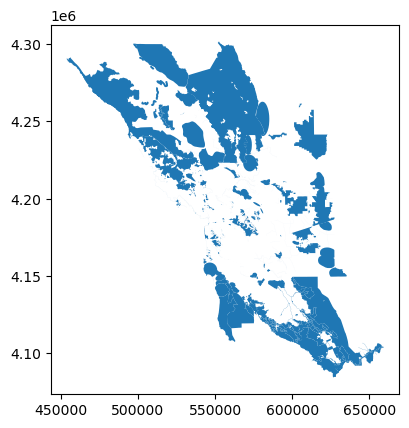

In [6]:
## Load PCA Geographies
## Pull GeoTable from AGOL as GeoDataframe
pca_geo['data_load'] = pull_geotable_agol(pca_geo['url'], client=client)
pca_geo['data_load'].plot()

natural_land
https://services3.arcgis.com/i2dkYWmb4wHvYPda/arcgis/rest/services/Natural_Land_PCA_Eligiblity/FeatureServer/669
Loading data for natural_land
Breaking feature service layer IDs into 3 chunks
Failed to load data for natural_land!

working_land
https://services3.arcgis.com/i2dkYWmb4wHvYPda/arcgis/rest/services/Working_Land_PCA_Eligibility/FeatureServer/225
Loading data for working_land
Breaking feature service layer IDs into 1 chunks
Data loaded successfully

urban_greening
https://services3.arcgis.com/i2dkYWmb4wHvYPda/arcgis/rest/services/Urban_Greening_PCA_Eligibility/FeatureServer/226
Loading data for urban_greening
Breaking feature service layer IDs into 1 chunks
Data loaded successfully

recreation
https://services3.arcgis.com/i2dkYWmb4wHvYPda/arcgis/rest/services/Regional_Recreation_PCA_Eligibility/FeatureServer/227
Loading data for recreation
Breaking feature service layer IDs into 1 chunks
Data loaded successfully

climate_adaptation
https://services3.arcgis.com/i2d

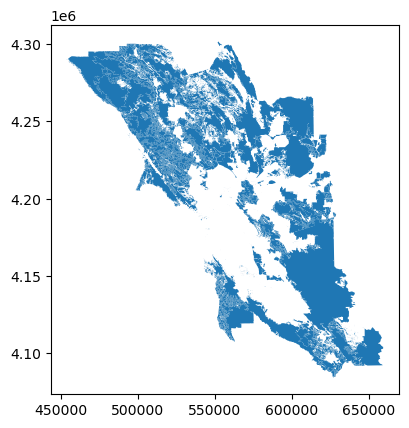

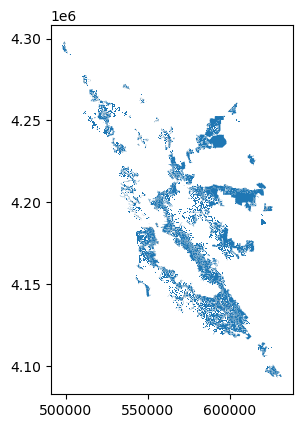

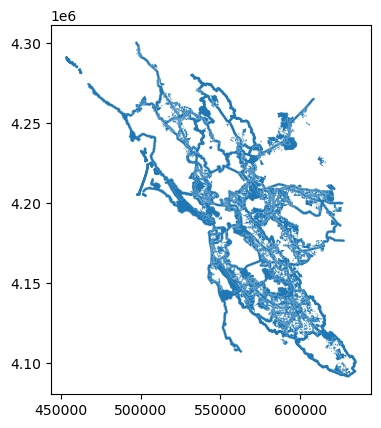

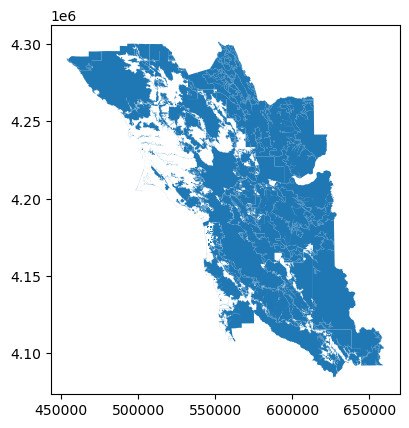

In [7]:
## Load PCA types
for i in pca_types.keys():
    print(i)
    print(pca_types[i]['url'])
    try:
        print(f"Loading data for {i}")
        ## Pull GeoTable from AGOL as GeoDataframe
        pca_types[i]['data_load'] = pull_geotable_agol(pca_types[i]['url'], client=client)
        pca_types[i]['data_load'].plot()
        print("Data loaded successfully\n")
    except:
        print(f"Failed to load data for {i}!\n")


## Create Footprints for PCA Types

Creating Footprint for dataset: natural_land
Using: data_load
Creation of Footprint failed!

Creating Footprint for dataset: working_land
Using: data_load
GDF Geometry Types: ['MultiPolygon']
Geodataframe contains valid geometry. No repair necessary.
GDF Geometry Types: ['Polygon']
Creation of Footprint completed

Creating Footprint for dataset: urban_greening
Using: data_load
GDF Geometry Types: ['MultiPolygon']
Geodataframe contains valid geometry. No repair necessary.
GDF Geometry Types: ['Polygon']
Creation of Footprint completed

Creating Footprint for dataset: recreation
Using: data_load
GDF Geometry Types: ['MultiPolygon' None]
Geodataframe contains valid geometry. No repair necessary.
GDF Geometry Types: ['Polygon']
Creation of Footprint completed

Creating Footprint for dataset: climate_adaptation
Using: data_load
GDF Geometry Types: ['MultiPolygon']
Geodataframe contains valid geometry. No repair necessary.
GDF Geometry Types: ['Polygon']
Creation of Footprint completed



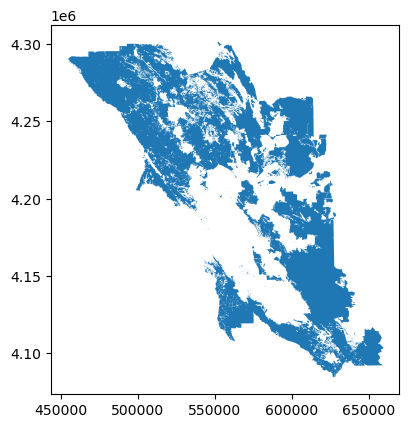

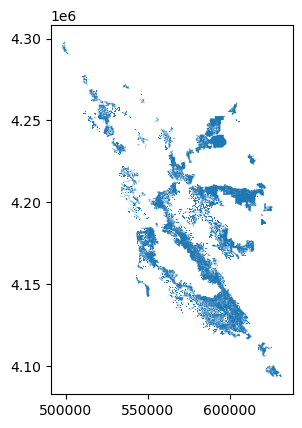

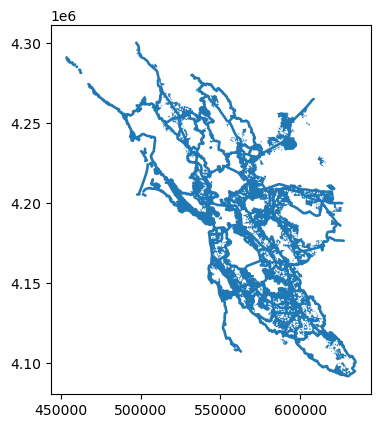

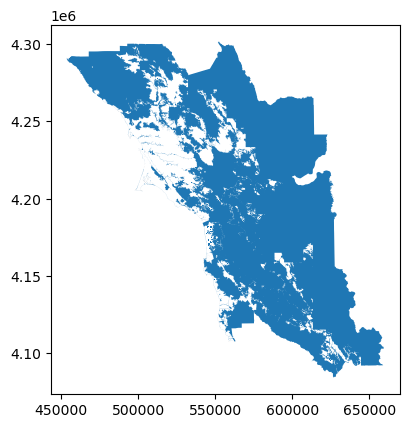

In [8]:
create_footprints_for_dict(pca_types, 'flag')

## Assign PCA Type Footprints to PCA Geographies

### Define Functions

In [9]:
def assign_footprint(
                gdf_base,
                gdf_over,
                flag_name,
                gdf_base_id="gdf_id",
                return_share=True
                ):
    """Given an Input Geodataframe, runs Spatial Overlay
    to p10 Parcels and returns Parcel Assignment crosswalk
    """
    ## Check for gdf_id or create
    if (gdf_base_id == 'gdf_id') and (not gdf_base_id in gdf_base.columns):
        print('Creating gdf_id')
        gdf_base.reset_index(drop=True, inplace=True)
        gdf_base['gdf_id'] = gdf_base.index
    ## Create Base GeoDataframe to Input GeoDataframe correspondence
    print('Creating Base GeoDataframe to Input GeoDataframe correspondence')
    gdf_over_corresp = geo_assign_fields(
        id_df=gdf_base[[gdf_base_id, 'geometry']],
        id_field=gdf_base_id,
        overlay_df=gdf_over,
        overlay_fields=[flag_name],
        return_intersection_area=return_share,
    )
    ## Merge p10 Parcels GeoDataframe to Input GeoDataframe using correspondence,
    ## return Dataframe
    gdf_base_fields = [i for i in gdf_base.columns if i != "geometry"]
    if return_share:
        if (not 'area_sq_m' in gdf_base.columns):
            print('Creating area_sq_m')
            gdf_base['area_sq_m'] = gdf_base.geometry.area
            gdf_base_fields.append("area_sq_m")
    base_over = pd.merge(gdf_base[gdf_base_fields], gdf_over_corresp, on=gdf_base_id, how="left")
    if return_share:
        intersect_area_col = f"{flag_name}_intersect_sq_m"
        share_pct_col = f"{flag_name}_share_pct"
        base_over.rename(columns={"intersection_sq_m": intersect_area_col}, inplace=True)
        base_over[share_pct_col] = base_over[intersect_area_col] / base_over["area_sq_m"]

    return base_over


def assign_footprints_from_dictionary(base_dict, overlay_dict, flag_col):
    """
    Assigns a footprint flag to base_dict for each item in the overlay_dict, based on flag_name.
    """
    for pca_type, type_att in overlay_dict.items():
        try:
            print(f'Dataset {pca_type}: Starting Assignment of Footprint')
            flag_name = type_att[flag_col]
            type_att['assignment'] = assign_footprint(
                gdf_base=base_dict['data_load'],
                gdf_over=type_att['footprint'],
                flag_name = flag_name
                )
            print(f'Dataset {pca_type}: Assignment of Footprint complete\n')
        except:
            print(f'Dataset {pca_type}: Assignment of Footprint failed!\n')
            pass

## Run Assignment

In [10]:
assign_footprints_from_dictionary(pca_geo, pca_types, 'flag')

Dataset natural_land: Starting Assignment of Footprint
Dataset natural_land: Assignment of Footprint failed!

Dataset working_land: Starting Assignment of Footprint
Creating gdf_id
Creating Base GeoDataframe to Input GeoDataframe correspondence
Running Overlay process
Running Overlay process successful
Processing final fields: ['gdf_id', '1wl']
took 3.0333 seconds
Creating area_sq_m
Dataset working_land: Assignment of Footprint complete

Dataset urban_greening: Starting Assignment of Footprint
Creating Base GeoDataframe to Input GeoDataframe correspondence
Running Overlay process
Running Overlay process successful
Processing final fields: ['gdf_id', '1ug']
took 10.7944 seconds
Dataset urban_greening: Assignment of Footprint complete

Dataset recreation: Starting Assignment of Footprint
Creating Base GeoDataframe to Input GeoDataframe correspondence
Running Overlay process
Running Overlay process successful
Processing final fields: ['gdf_id', '1r']
took 2.2957 seconds
Dataset recreation

In [11]:
for pca_type, type_att in pca_types.items():
    try:
        print('Displaying Assignment of Footprint for PCA Type:', pca_type)
        display(type_att['assignment'].sample(3))
    except:
        print(f'Display of Assignment of Footprint for PCA Type {pca_type} failed!')

Displaying Assignment of Footprint for PCA Type: natural_land
Display of Assignment of Footprint for PCA Type natural_land failed!
Displaying Assignment of Footprint for PCA Type: working_land


,OBJECTID,fipco,joinkey,lead,name,acres,typenl,typeal,typeug,typerr,...,INSIDE_Y,PCA,Acreage,Shape__Area,Shape__Length,gdf_id,area_sq_m,1wl,1wl_intersect_sq_m,1wl_share_pct
33,34,6001,AL18,City of Fremont,Site 1-Coyote Hills,379.622826,1,0,0,0,...,37.551809,1,379.622826,1.536279e+06,6209.533986,33,1.536281e+06,1.0,989040.196423,0.643788
127,128,6085,SC49,Santa Clara Valley Open Space Authority,Coyote Valley - North,1642.230035,0,0,1,0,...,37.201817,1,1642.230035,6.645869e+06,15329.367158,127,6.645891e+06,1.0,9689.349582,0.001458
104,105,6081,MULTI5,"San Mateo County, on behalf of the State Coast...",San Francisco Bay Area Water Trail,1.492519,0,0,0,1,...,37.663955,1,1.492519,6.040014e+03,994.598253,104,6.040011e+03,1.0,5.370396,0.000889


Displaying Assignment of Footprint for PCA Type: urban_greening


,OBJECTID,fipco,joinkey,lead,name,acres,typenl,typeal,typeug,typerr,...,INSIDE_Y,PCA,Acreage,Shape__Area,Shape__Length,gdf_id,area_sq_m,1ug,1ug_intersect_sq_m,1ug_share_pct
98,99,6041,MULTI5,"San Mateo County, on behalf of the State Coast...",San Francisco Bay Area Water Trail,3.214656,0,0,0,1,...,38.114638,1,3.214656,1.300925e+04,2142.211400,98,1.300918e+04,1.0,1490.218731,0.114551
72,73,6085,SC2,Midpeninsula Regional Open Space District,Upper Los Gatos Creek Watershed,7791.469923,1,0,0,1,...,37.133963,1,7791.469923,3.153096e+07,26439.858092,72,3.153120e+07,NaN,NaN,NaN
74,75,6097,SN5,Laguna de Santa Rosa Foundation,Santa Rosa Plain,14662.021199,1,0,0,0,...,38.426948,1,14662.021199,5.933509e+07,68868.469534,74,5.933550e+07,1.0,447303.535082,0.007539


Displaying Assignment of Footprint for PCA Type: recreation


,OBJECTID,fipco,joinkey,lead,name,acres,typenl,typeal,typeug,typerr,...,INSIDE_Y,PCA,Acreage,Shape__Area,Shape__Length,gdf_id,area_sq_m,1r,1r_intersect_sq_m,1r_share_pct
65,66,6085,SC7,Santa Clara County Parks & Recreation Department,Anderson/Coyote Connection,2840.485442,1,1,0,1,...,37.144048,1,2840.485442,1.149504e+07,29704.808738,65,1.149498e+07,1.0,5.570566e+06,0.484608
167,168,6085,SC31,Midpeninsula Regional Open Space District,Cupertino Open Space,245.501733,1,0,0,1,...,37.331180,1,245.501733,9.935103e+05,12134.757189,167,9.935115e+05,1.0,5.565715e+05,0.560206
98,99,6041,MULTI5,"San Mateo County, on behalf of the State Coast...",San Francisco Bay Area Water Trail,3.214656,0,0,0,1,...,38.114638,1,3.214656,1.300925e+04,2142.211400,98,1.300918e+04,1.0,1.254456e+04,0.964286


Displaying Assignment of Footprint for PCA Type: climate_adaptation


,OBJECTID,fipco,joinkey,lead,name,acres,typenl,typeal,typeug,typerr,...,INSIDE_Y,PCA,Acreage,Shape__Area,Shape__Length,gdf_id,area_sq_m,1ca,1ca_intersect_sq_m,1ca_share_pct
45,46,6013,CC9,East Bay Municipal Utility District,Indian Valley,646.300590,1,0,0,0,...,37.830692,1,646.300590,2.615486e+06,8563.691548,45,2.615491e+06,1,2.575187e+06,0.984590
5,6,6095,SL1,City of Fairfield,Vacaville-Fairfield-Solano Greenbelt and Cemen...,4545.218173,1,1,1,0,...,38.309403,1,4545.218173,1.839385e+07,34392.899117,5,1.839380e+07,1,1.839380e+07,1.000000
94,95,6081,MULTI4,"San Mateo County, on behalf of the State Coast...",California Coastal Trail,205.277792,0,0,0,1,...,37.118606,1,205.277792,8.307297e+05,135667.711481,94,1.241529e+06,1,2.290735e+05,0.184509


## Integrate Assignments of PCA Types to singe Assignment file

In [12]:
data_key = "data" if "data" in pca_geo.keys() else "data_load"
pca_geo['assignment'] = pca_geo[data_key].drop(columns=['geometry'])
## Merge PCA Geogrphies to PCA Types Assignments 
for pca_type, type_att in pca_types.items():
    try:
        flag = type_att['flag']
        cols = ['gdf_id', flag, f"{flag}_intersect_sq_m", f"{flag}_share_pct"]
        pca_geo['assignment'] = pd.merge(
            pca_geo['assignment'],
            type_att['assignment'][cols].fillna(0),
            on='gdf_id',
            how='left'
            )
        print(f'Assignment of Footprint for PCA Type {pca_type} completed\n')
    except:
        print(f'Assignment of Footprint for PCA Type {pca_type} failed!\n')

Assignment of Footprint for PCA Type natural_land failed!

Assignment of Footprint for PCA Type working_land completed

Assignment of Footprint for PCA Type urban_greening completed

Assignment of Footprint for PCA Type recreation completed

Assignment of Footprint for PCA Type climate_adaptation completed



### Check samples from Integrated Assignments table

In [13]:
pca_geo['assignment'].sample(3).T

,178,48,132
OBJECTID,179,49,133
fipco,6055,6013,6085
joinkey,NP8,CC19,SC60
lead,Save-the-Redwoods League,East Bay Regional Park District (EBRPD),Santa Clara Valley Open Space Authority
name,Bothe-Napa Valley State Park to Sugarloaf Ridg...,Delta Recreation Area,Gilroy Foothills
acres,31374.446313,13894.675188,749.168298
typenl,1,1,1
typeal,0,0,1
typeug,0,0,0
typerr,0,1,1


## Export Integrated Assignments as Table

In [14]:
pca_geo['assignment'].fillna(0).to_csv('pca_type_assignment.csv', index=False)